In [106]:
from yx import csp_yx
import matplotlib.pyplot as plt

In [107]:
import scipy.io as sio
import numpy as np
dataSetfile = "../L-R hand/dataset_BCIcomp1.mat"
testLabelfile = "../test/labels_data_set_iii.mat"
EEGSignals = sio.loadmat(dataSetfile)
LabelSet = sio.loadmat(testLabelfile)


# EEGSignals_x_train = np.concatenate([EEGSignals['x_train'],EEGSignals['x_test']], axis=2)
# EEGSignals_y_train = np.concatenate([EEGSignals['y_train'],LabelSet['y_test']])


EEGSignals_x_train = EEGSignals['x_train']
EEGSignals_y_train = EEGSignals['y_train']

In [108]:
EEGSignals_y_train.shape

(140, 1)

In [109]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# X,Y = shuffle(EEGSignals_x_train,EEGSignals_y_train,random_state=1280) 
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8,shuffle=True)

/Users/yuanxue/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [110]:
samplePointStart = 3
samplePointEnd = 6
sfreq = 128
EEGSignals_x_train = EEGSignals_x_train[samplePointStart*sfreq:samplePointEnd*sfreq,:,:]

In [111]:
def csp_yx(EEGSignals_x_train,EEGSignals_y_train):
    
    import numpy as np
    
    EEG_Channels = 3
    EEG_Trials = 140
    EEG_Classes = 2
    class_labels = [1, 2]
    
    
    
    # 计算协方差矩阵 cov1 cov2
    trialCov = np.zeros((EEG_Channels,EEG_Channels,EEG_Trials))
    for i in range(140):
        E = EEGSignals_x_train[:,:,i].T
    #     print(E.shape)
        EE = np.dot(E,E.T)
        trialCov[:,:,i] = EE/np.trace(EE);    

    
    
    cov1 = np.zeros((EEG_Channels,EEG_Channels,70))
    cov2 = np.zeros((EEG_Channels,EEG_Channels,70))
    
    MatrixCov = np.zeros((3,3,2))
    k=0
    s=0
    for i in range(EEG_Channels):
        if EEGSignals_y_train[i] == 1:
            cov1[:,:,k] = trialCov[:,:,i]
            k=k+1
        if EEGSignals_y_train[i] == 2:
            cov2[:,:,s] = trialCov[:,:,i]
            s=s+1
            
    np.set_printoptions(precision=4)
    
    # 计算平均协方差矩阵之和 covTotal
    cov1 = np.mean(cov1,2)
    cov2 = np.mean(cov2,2)
    covTotal = cov1 + cov2
    print(covTotal)
    
    # 计算公共特征向量矩阵和特征值
    [Dt,Uc] = np.linalg.eigh(covTotal)
    # 降序排序
    Uc = Uc[:,abs(Dt).argsort()[::-1]]
    Dt = sorted(abs(Dt),reverse=True)
    
    # 矩阵白化
    Dt = np.diag(Dt)
    Dt = np.sqrt(1./Dt)
  
    # 去 inf值
    c = np.isinf(Dt)
    Dt[c] = 0
    print(Dt)
    P = np.dot(Dt,Uc.T)
    
#     print(P)
   
    # 将P作用于 cov1 cov2
    transformedCov1 = np.dot(np.dot(P,cov1),P.T)
    transformedCov2 = np.dot(np.dot(P,cov2),P.T)  # S1 = P*R1*P.T
   

    # 将 transformedCov1 按主分量分解得到公共特征向量矩阵 B
    
    [D1,U1] = np.linalg.eig(transformedCov1)
    # 降序
    U1 = U1[:,abs(D1).argsort()]
    D1 = sorted(abs(D1),reverse=True)

#     print(U1)
    
    [D2,U2] = np.linalg.eig(transformedCov2)
    # 升序
    U2 = U2[:,abs(D2).argsort()]
    D2 = np.sort(abs(D2))
#     print(U2)

    
    # 计算投影矩阵
    CSPMatrix = np.dot(U1.T,P)
    
    return CSPMatrix


In [112]:
W = csp_yx(EEGSignals_x_train,EEGSignals_y_train)

[[0.0158 0.0112 0.0092]
 [0.0112 0.0135 0.0096]
 [0.0092 0.0096 0.0136]]
[[ 5.3914  0.      0.    ]
 [ 0.     13.6203  0.    ]
 [ 0.      0.     18.0673]]


/Users/yuanxue/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


In [113]:
FilterPairs = 3      # CSP特征选择参数m
features_train = np.zeros((140, 2*FilterPairs))
# features_test = np.zeros((80, 2*FilterPairs))

m1 = W[0:FilterPairs]
m2 = W[3-FilterPairs:3]

Filter = np.concatenate([m1,m2])
Filter = abs(Filter)
Filter

array([[11.0057, 10.2115,  3.5548],
       [ 5.9966,  3.0307, 11.8433],
       [ 1.554 , 10.6575,  1.2517],
       [11.0057, 10.2115,  3.5548],
       [ 5.9966,  3.0307, 11.8433],
       [ 1.554 , 10.6575,  1.2517]])

In [114]:
data = np.concatenate([EEGSignals['x_train'],EEGSignals['x_test']],axis=2)

projectedTrial = np.zeros((2*FilterPairs,384))
EEG_Trials = 140
for i in range(EEG_Trials):
    # 将源信号投影到 CSP空间上
    projectedTrial = np.dot(Filter,data[:,:,i].T)
        
    # 将投影信号的方差得对数作为特征
    variances_train = np.var(projectedTrial,1)
    for f in range(len(variances_train)):
        features_train[i,f] = np.log(variances_train[f]/sum(abs(variances_train)))



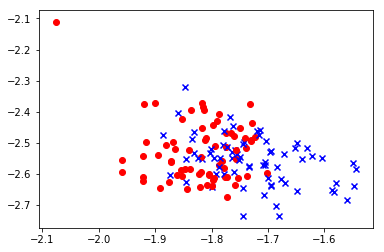

In [103]:
for i in range(140):
    if EEGSignals_y_train[i]==1:
        plt.scatter(features_train[i,1],features_train[i,2],color='red',marker='o',label='left')
    if EEGSignals_y_train[i]==2:
        plt.scatter(features_train[i,1],features_train[i,2],color='blue',marker='x',label='right')

In [118]:
features_train.shape

(140, 6)

In [122]:
left = np.zeros(70)
right = np.zeros(70)
k = 0
l = 0
for i in range(140):
    if EEGSignals_y_train[i]==1:
        left[k] = np.mean(features_train[i])
        k = k+1
    else:
        right[l] = np.mean(features_train[i])
        l=l+1

In [126]:
np.mean(left)

-1.9019383426588514

In [127]:
np.mean(right)

-1.8993878032683236

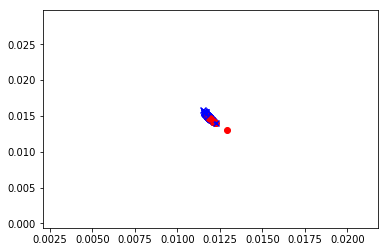

In [123]:
for i in range(140):
    if EEGSignals_y_train[i]==1:
        plt.scatter(np.mean(features_train[i,0:2]/sum(left)),np.mean(features_train[i,2:4]/sum(left)),color='red',marker='o',label='left')
    if EEGSignals_y_train[i]==2:
        plt.scatter(np.mean(features_train[i,0:2]/sum(right)),np.mean(features_train[i,2:4]/sum(right)),color='blue',marker='x',label='right')
        
        

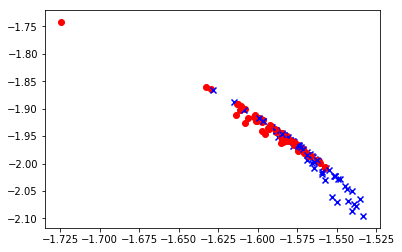

In [62]:
for i in range(140):
    if EEGSignals_y_train[i]==1:
        plt.scatter(np.mean(features_train[i,0:2]),np.mean(features_train[i,2:4]),color='red',marker='o',label='left')
    if EEGSignals_y_train[i]==2:
        plt.scatter(np.log(features_train[i,0:2]/sum(features_train)),np.mean(features_train[i,2:4]),color='blue',marker='x',label='right')

In [63]:
CSP = features_train[7,:2]
CSP

array([-1.4934, -1.5827])

In [82]:
import numpy as np                
from matplotlib import colors     
from sklearn import svm            
from sklearn import model_selection
import matplotlib.pyplot as plt
import matplotlib as mpl

In [83]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier


X_Train,y_Train = shuffle(features_train,EEGSignals_y_train) 
y_Train = np.subtract(np.array(y_Train), 1)
y_Train = y_Train.reshape([140,1])
# y_Train


In [84]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_train, EEGSignals_y_train, random_state=1, train_size=0.7)

/Users/yuanxue/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [85]:
# SVM分类器构建
def classifier():
    clf = svm.SVC(kernel='rbf',gamma=30,decision_function_shape='ovo',C=50) #决策函数
#     clf = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma=0.0, coef0=0.0, shrinking=True, probability=False,tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=None)
    return clf

In [86]:
# 定义模型：SVM模型定义
clf = classifier()


In [87]:
def train(clf,x_train,y_train):
    clf.fit(x_train,         #训练集特征向量
            y_train.ravel()) #训练集目标值



In [88]:
# 训练SVM模型
train(clf,x_train,y_train)

In [89]:
# 并判断a b是否相等，计算acc的均值
def show_accuracy(a, b, tip):
    acc = a.ravel() == b.ravel()
    print('%s Accuracy:%.3f' %(tip, np.mean(acc)))



In [90]:
def print_accuracy(clf,x_train,y_train,x_test,y_test):
    #分别打印训练集和测试集的准确率  score(x_train,y_train):表示输出x_train,y_train在模型上的准确率
    print('trianing prediction:%.3f' %(clf.score(x_train, y_train)))
    print('test data prediction:%.3f' %(clf.score(x_test, y_test)))



In [91]:
 # predict()表示对x_train样本进行预测，返回样本类别
print('train_size:',y_train.shape)
print('test_size:',y_test.shape)
show_accuracy(clf.predict(x_train), y_train, 'traing data')
show_accuracy(clf.predict(x_test), y_test, 'testing data')



train_size: (98, 1)
test_size: (42, 1)
traing data Accuracy:0.806
testing data Accuracy:0.738


In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm

# from data import feature_train, target_train, feature_test, target_test

svm_classifier = svm.SVC(C=1.0, kernel='rbf', decision_function_shape='ovr', gamma=0.01)
svm_classifier.fit(feature_train, target_train)

print("训练集:", svm_classifier.score(feature_train,EEGSignals_y_train))
print("测试集:", svm_classifier.score(feature_test, EEGSignals_y_train))
target_test_predict = svm_classifier.predict(feature_test)
comp = zip(target_test, target_test_predict)
print(list(comp))

plt.figure()
plt.subplot(121)
plt.scatter(feature_test[:, 0], feature_test[:, 1], c=target_test.reshape((-1)), edgecolors='k', s=50)
plt.subplot(122)
plt.scatter(feature_test[:, 0], feature_test[:, 1], c=target_test_predict.reshape((-1)), edgecolors='k', s=50)
plt.show()



# mne

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
 
###############################################################################
tmin, tmax = -1., 4.  #设置参数，记录点的前1秒后4秒用于生成epoch数据
event_id = dict(hands=2, feet=3) #设置事件的映射关系
subject = 1
runs = [6, 10, 14]
# 获取想要读取的文件名称，这个应该是没有会默认下载的数据
raw_fnames = eegbci.load_data(subject, runs)
# 将3个文件的数据进行拼接
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
# 去掉通道名称后面的（.），不知道为什么默认情况下raw.info['ch_names']中的通道名后面有的点
raw.rename_channels(lambda x: x.strip('.'))
# 对原始数据进行FIR带通滤波
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')#
# 从annotation中获取事件信息
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))



# 剔除坏道，提取其中有效的EEG数据
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
# 根据事件生成对应的Epochs数据
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
# 截取其中的1秒到2秒之间的数据，也就是提示音后1秒到2秒之间的数据（这个在后面滑动窗口验证的时候有用）
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
# 将events转换为labels,event为2,3经过计算后也就是0,1
labels = epochs.events[:, -1] - 2



In [33]:
import scipy.io as sio
import numpy as np
# load data 
dataSetfile = "../L-R hand/dataset_BCIcomp1.mat"
testLabelfile = "../test/labels_data_set_iii.mat"

LabelSet = sio.loadmat(testLabelfile)

EEGSignals = sio.loadmat(dataSetfile)
EEGSignals_x_train = np.concatenate([EEGSignals['x_train'],EEGSignals['x_test']], axis=2)
EEGSignals_y_train = np.concatenate([EEGSignals['y_train'],LabelSet['y_test']])

EEG_Channels = 3
EEG_Trials = 280
EEG_Classes = 2
class_labels = [1, 2]

In [34]:
c = EEGSignals_x_train[:,:,1]
c.shape

(1152, 3)

In [35]:
trialCov = np.zeros((EEG_Channels,EEG_Channels,EEG_Trials))

In [36]:
for i in range(280):
    E = EEGSignals_x_train[:,:,i].T
#     print(E.shape)
    EE = np.dot(E,E.T)
    trialCov[:,:,i] = EE/np.trace(EE);  

In [37]:
np.set_printoptions(precision=4)

In [38]:
cov1 = np.zeros((EEG_Channels,EEG_Channels,140))
cov2 = np.zeros((EEG_Channels,EEG_Channels,140))
MatrixCov = np.zeros((3,3,2))

k=0
s=0
for i in range(280):
    if EEGSignals_y_train[i] == 1:
        cov1[:,:,k] = trialCov[:,:,i]
        k=k+1
    if EEGSignals_y_train[i] == 2:
        cov2[:,:,s] = trialCov[:,:,i]
        s=s+1

In [39]:
cov1 = np.mean(cov1,2)
cov2 = np.mean(cov2,2)
covTotal = cov1 + cov2
covTotal

array([[0.7207, 0.5054, 0.3875],
       [0.5054, 0.635 , 0.4633],
       [0.3875, 0.4633, 0.6444]])

In [40]:
[Dt,Uc] = np.linalg.eig(covTotal)
Uc = Uc[:,Dt.argsort()[::-1]]
Dt = sorted(Dt,reverse=True)

In [41]:
Dt

[1.5729537765057309, 0.2932442363315419, 0.1338019871627259]

In [42]:
Dt = np.diag(Dt)
Dt = np.sqrt(1./Dt)

/Users/yuanxue/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [43]:
c = np.isinf(Dt)
Dt[c] = 0

In [44]:
Dt

array([[0.7973, 0.    , 0.    ],
       [0.    , 1.8467, 0.    ],
       [0.    , 0.    , 2.7338]])

In [45]:
Uc.T

array([[-0.597 , -0.5901, -0.5435],
       [-0.681 ,  0.0146,  0.7321],
       [ 0.4241, -0.8072,  0.4106]])

In [46]:
P = np.dot(Dt,Uc.T)

In [47]:
P

array([[-0.476 , -0.4705, -0.4333],
       [-1.2576,  0.027 ,  1.352 ],
       [ 1.1593, -2.2067,  1.1225]])

In [48]:
transformedCov1 = np.dot(np.dot(P,cov1),P.T)
transformedCov2 = np.dot(np.dot(P,cov2),P.T)

In [49]:
transformedCov1

array([[ 0.5056,  0.048 ,  0.013 ],
       [ 0.048 ,  0.4667, -0.026 ],
       [ 0.013 , -0.026 ,  0.5075]])

In [50]:
[D1,U1] = np.linalg.eig(transformedCov1)
# 降序
U1 = U1[:,D1.argsort()]
D1 = sorted(D1,reverse=True)

[D2,U2] = np.linalg.eig(transformedCov2)
# 升序
U2 = U2[:,D2.argsort()]
D2 = np.sort(D2)
print(D1)
print(D2)

[0.5385562956851275, 0.5168626473729773, 0.4243509963645974]
[0.4614 0.4831 0.5756]


In [51]:
transformedCov1

array([[ 0.5056,  0.048 ,  0.013 ],
       [ 0.048 ,  0.4667, -0.026 ],
       [ 0.013 , -0.026 ,  0.5075]])

In [52]:
[D1,U1] = np.linalg.eig(transformedCov1)
D1

array([0.4244, 0.5386, 0.5169])

In [53]:
[D2,B2] = np.linalg.eig(transformedCov2)
D2

array([0.5756, 0.4614, 0.4831])

In [54]:
CSPMatrix = np.dot(U1.T,P)

In [55]:
CSPMatrix

array([[ 3.6592e-01,  4.5756e-01, -1.6601e+00],
       [ 1.3043e+00, -2.0970e-05, -2.7008e-01],
       [ 1.1476e+00, -2.2096e+00,  6.6844e-01]])

In [56]:
FilterPairs = 1       # CSP特征选择参数m
features_train = np.zeros((280, 2*FilterPairs))
# features_test = np.zeros((80, 2*FilterPairs))

m1 = CSPMatrix[0:FilterPairs]
m2 = CSPMatrix[3-FilterPairs:3]

Filter = np.concatenate([m1,m2])
Filter

array([[ 0.3659,  0.4576, -1.6601],
       [ 1.1476, -2.2096,  0.6684]])

In [57]:
data = np.concatenate([EEGSignals['x_train'],EEGSignals['x_test']],axis=2)

projectedTrial = np.zeros((2*FilterPairs,1152))

for i in range(EEG_Trials):
    # 将源信号投影到 CSP空间上
    projectedTrial = np.dot(Filter,data[:,:,i].T)
        
    # 将投影信号的方差得对数作为特征
    variances_train = np.var(projectedTrial,1)
    for f in range(len(variances_train)):
        features_train[i,f] = np.log(variances_train[f])


In [58]:
CSP = features_train[:,0:2]

In [59]:
CSP

array([[-4.937 , -4.679 ],
       [-4.7594, -4.9566],
       [-4.9996, -4.9785],
       [-4.6977, -4.7697],
       [-4.5586, -4.6966],
       [-4.3995, -4.7476],
       [-4.9687, -4.7659],
       [-4.0282, -5.0187],
       [-4.6098, -4.9587],
       [-4.733 , -4.9407],
       [-4.3976, -4.8441],
       [-4.3839, -4.9846],
       [-4.9511, -4.7687],
       [-4.0545, -4.9121],
       [-4.3983, -4.6116],
       [-4.1374, -4.8903],
       [-4.0777, -4.2483],
       [-4.2081, -4.8505],
       [-4.3474, -4.5136],
       [-5.0339, -4.7017],
       [-4.7548, -4.5406],
       [-4.7135, -4.515 ],
       [-5.3275, -4.861 ],
       [-4.3482, -4.9505],
       [-5.1895, -4.8317],
       [-4.0714, -4.4315],
       [-5.0352, -4.7917],
       [-4.7228, -4.5053],
       [-4.0243, -4.1323],
       [-4.2357, -4.2608],
       [-4.561 , -4.4544],
       [-3.9315, -4.1187],
       [-4.3334, -4.581 ],
       [-4.5227, -4.7152],
       [-4.6201, -4.6349],
       [-4.5461, -4.7028],
       [-4.6381, -4.6825],
 

In [ ]:
for t=1:EEG_Trials    
    %projecting the data onto the CSP filters    
    projectedTrial_train = Filter * EEGSignals.x_train(:,:,t)';    
    projectedTrial_test = Filter * EEGSignals.x_test(:,:,t)';
    
    %generating the features as the log variance of the projected signals
    variances_train = var(projectedTrial_train,0,2);  
    variances_test = var(projectedTrial_test,0,2);
    for f=1:length(variances_train)
        features_train(t,f) = log(variances_train(f));
        % features_train(t,f) = log(variances_train(f)/sum(variances_train));   %修改后对应公式
    end
    for f=1:length(variances_test)
        features_test(t,f) = log(variances_test(f));
        %features_test(t,f) = log(variances_test(f)/sum(variances_test));  % 修改后对应公式

In [ ]:
#从每一次实验中提取CSP特征
for t in range(EEG_Trials):
    
    # 将数据投影到CSP空间
    projectedTrial_train = Filter.dot(trainData[t])
    projectedTrial_test = Filter.dot(trainData[t])
    
    # 投影后信号的方差作为特征
    variances_train = np.var(projectedTrial_train, 1)
    variances_test = np.var(projectedTrial_test, 1)
    
    for f in range(len(variances_train)):
        feature_train[t, f] = np.log(variances_train[f])
 
    for f in range(len(variances_test)):
        feature_test[t, f] = np.log(variances_test[f])
 
 
 

In [ ]:
clc;
clear;
EEGSignals = load('/Users/yuanxue/BCI/MI/L-R hand/dataset_BCIcomp1.mat');   % 加载带通滤波后的脑电数据
%check and initializations
EEG_Channels = size(EEGSignals.x_train,2);
EEG_Trials = size(EEGSignals.x_train,3);
classLabels = unique(EEGSignals.y_train);% Return non-repeating values
EEG_Classes = length(classLabels);
covMatrix = cell(EEG_Classes,1); % 协方差矩阵
% Computing the normalized covariance matrices for each trial
trialCov = zeros(EEG_Channels,EEG_Channels,EEG_Trials);
for i = 1:EEG_Trials
    E = EEGSignals.x_train(:,:,i)';
    EE = E*E';
    trialCov(:,:,i) = EE./trace(EE);  % 计算协方差矩阵
end
clear E;
clear EE;
% 计算每一类样本数据的空间协方差之和
for i = 1:EEG_Classes
    covMatrix{i} = mean(trialCov(:,:,EEGSignals.y_train == classLabels(i)),3);
end

% 计算两类数据的空间协方差之和
covTotal = covMatrix{1} + covMatrix{2};

% 计算特征向量和特征矩阵
[Uc,Dt] = eig(covTotal);
% 特征值要降序排列
Dt = diag(Dt);
[Dt,egIndex] = sort(Dt, 'descend');% 降序
Ut = Uc(:,egIndex);

c = diag(sqrt(1./Dt))


% 矩阵白化
P = c*Ut';


     



% 矩阵P作用求公共特征向量transformedCov1 
transformedCov1 = P*covMatrix{1}*P';
transformedCov2 = P*covMatrix{2}*P';
     

%计算公共特征向量transformedCov1的特征向量和特征矩阵
[U1,D1] = eig(transformedCov1);
%计算公共特征向量transformedCov2的特征向量和特征矩阵
[U2,D2] = eig(transformedCov2);

     
     
eigenvalues = diag(D1);
[eigenvalues,egIndex] = sort(eigenvalues, 'descend');% 降序排列
U1 = U1(:, egIndex);

     
     
eigenvalues2 = diag(D2);
[eigenvalues2,egIndex2] = sort(eigenvalues2, 'descend');% 降序排列
U2 = U2(:, egIndex2);


% 计算投影矩阵W
CSPMatrix = U1' * P;


% 计算特征矩阵
FilterPairs = 1;       % CSP特征选择参数m    CSP特征为2*m个
features_train = zeros(EEG_Trials, 2*FilterPairs+1);
features_test = zeros(EEG_Trials, 2*FilterPairs+1);
Filter = CSPMatrix([1:FilterPairs (end-FilterPairs+1):end],:);
%extracting the CSP features from each trial
for t=1:EEG_Trials    
    %projecting the data onto the CSP filters    
    projectedTrial_train = Filter * EEGSignals.x_train(:,:,t)';    
    projectedTrial_test = Filter * EEGSignals.x_test(:,:,t)';
    %generating the features as the log variance of the projected signals
    variances_train = var(projectedTrial_train,0,2);  
    variances_test = var(projectedTrial_test,0,2);
    for f=1:length(variances_train)
        features_train(t,f) = log(variances_train(f));
        % features_train(t,f) = log(variances_train(f)/sum(variances_train));   %修改后对应公式
    end
    for f=1:length(variances_test)
        features_test(t,f) = log(variances_test(f));
        %features_test(t,f) = log(variances_test(f)/sum(variances_test));  % 修改后对应公式
    end
disp(features_train(:,1:2))

In [ ]:

%计算特征矩阵
FilterPairs = 2
feature_train = np.zeros([EEG_Trials, 2*FilterPairs+1])

feature_test = np.zeros([EEG_Trials, 2*FilterPairs+1])

Filter = np.r_[CSPMatrix[:FilterPairs], CSPMatrix[-FilterPairs:]]
 
%从每一次实验中提取CSP特征
for t in range(EEG_Trials):
    %将数据投影到CSP空间
    projectedTrial_train = Filter.dot(trainData[t])
    projectedTrial_test = Filter.dot(trainData[t])
    %投影后信号的方差作为特征
    variances_train = np.var(projectedTrial_train, 1)
    variances_test = np.var(projectedTrial_test, 1)
    for f in range(len(variances_train)):
        feature_train[t, f] = np.log(variances_train[f])
 
    for f in range(len(variances_test)):
        feature_test[t, f] = np.log(variances_test[f])
 
 
CSP_Train_faetures = feature_train[:, 0:4]
CSP_Test_features = feature_test[:, 0:4]
